## number and area - example

number index and area fraction -  Number of contiguous convective regions (objects) in a scene given that the total area is roughly fixed
<br>
area distribution - The area of different objects over time

In [1]:
import xarray as xr

import numpy as np
import skimage.measure as skm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import os

import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

import myPlots
import myFuncs

## convective regions from precipitation fields

### from local

In [2]:
model = 'GFDL-CM3'
experiment = 'historical'
folder = '/Users/cbla0002/Documents/data/cmip5/' + model

In [3]:
fileName = model + '_pr4_' + experiment + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)

In [4]:
ds

<xarray.Dataset>
Dimensions:   (time: 4, lat: 22, lon: 128)
Coordinates:
  * time      (time) object 1970-01-01 12:00:00 ... 1970-01-04 12:00:00
  * lat       (lat) float64 -29.3 -26.51 -23.72 -20.93 ... 23.72 26.51 29.3
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
Data variables:
    pr4_days  (time, lat, lon) float32 ...

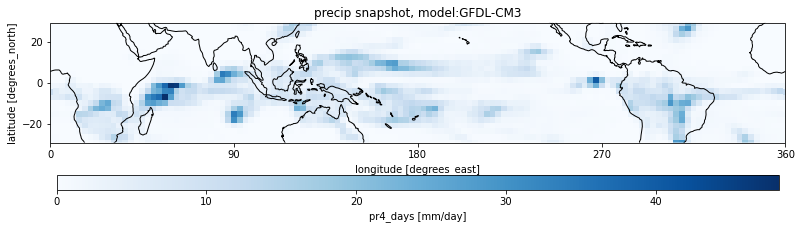

In [5]:
myPlots.plot_snapshot(ds.pr4_days.isel(time=0), 'Blues', 'precip', model)

In [6]:
fileName = model + '_pr_extreme_' + experiment + '.nc'
path = folder + '/' + fileName
ds_percentile = xr.open_dataset(path)

In [7]:
ds_percentile

<xarray.Dataset>
Dimensions:  (time: 10950)
Coordinates:
  * time     (time) object 1970-01-01 12:00:00 ... 1999-12-31 12:00:00
Data variables:
    pr_97    (time) float64 ...
    pr_99    (time) float64 ...
    pr_999   (time) float64 ...

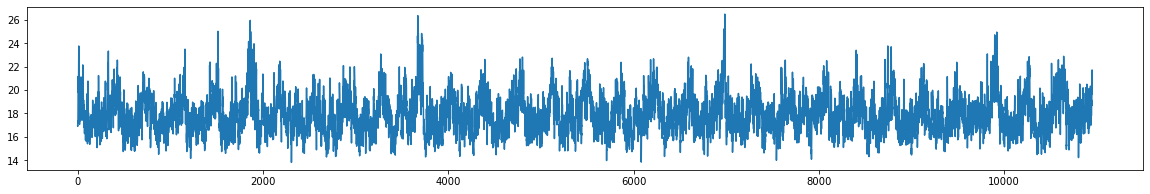

In [8]:
plt.figure(figsize= (20,3))
plt.plot(ds_percentile.pr_97.data)

In [9]:
pr_day = ds.pr4_days.isel(time=0)

In [11]:
# label 8-connected (2-connectivity) objects
conv_threshold = ds_percentile.pr_97.mean(dim=('time'))
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2)
myFuncs.connect_boundary(L)

In [12]:
L_xr = xr.DataArray(
    data=L,
    dims=['lat', 'lon'],
    coords={'lat': pr_day.lat.data, 'lon': pr_day.lon.data}
    )

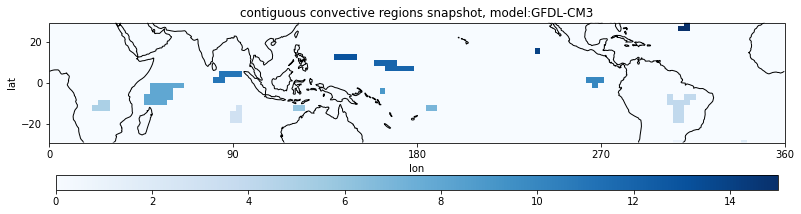

In [13]:
myPlots.plot_snapshot(L_xr, 'Blues', 'contiguous convective regions', model)

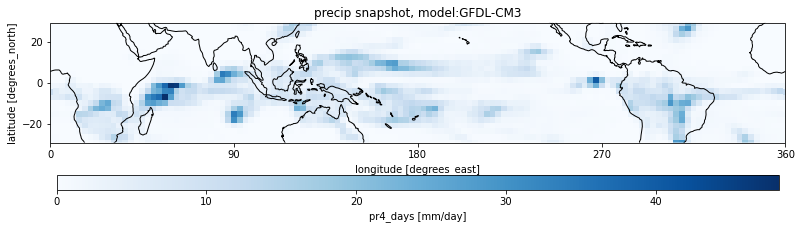

In [14]:
# for comparison
myPlots.plot_snapshot(ds.pr4_days.isel(time=0), 'Blues', 'precip', model)

## convective object properties

In [15]:
# scene to calculate index from
pr_day = ds.pr4_days.isel(time=0)
pr_day3d = np.expand_dims(pr_day,axis=2) # used for broadcasting
lat = pr_day.lat
lon = pr_day.lon
conv_threshold = ds_percentile.pr_97.mean(dim=('time'))
L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2)
myFuncs.connect_boundary(L)
labels = np.unique(L)[1:]

In [17]:
# dimensions used for calculation
lat = pr_day.lat.data
lon = pr_day.lon.data
lonm,latm = np.meshgrid(lon,lat)
dlat = (lat[1]-lat[0])
dlon = (lon[1]-lon[0])
R = 6371
aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
lonm3d = np.expand_dims(lonm,axis=2)
aream3d = np.expand_dims(aream,axis=2) 
shape_L = np.shape(L)

In [18]:
# number index and area fraction of a scene
numberIndex_scene = len(labels)
conv_day = (pr_day.where(pr_day>=conv_threshold,0)>0)*1
areaf_scene = np.sum(conv_day * aream)/np.sum(aream)

# aWeights = np.cos(np.deg2rad(lat))
# areaf_scene = conv_day.weighted(aWeights).mean(dim=('lat','lon'))

In [19]:
np.float32(areaf_scene)

0.028038016

In [82]:
# for multiple scenes as function
def calc_numberIndex(precip, listOfdays, conv_threshold):
    numberIndex, areaf = [], []

    lat = precip.lat.data
    lon = precip.lon.data
    lonm,latm = np.meshgrid(lon,lat)
    dlat = (lat[1]-lat[0])
    dlon = (lon[1]-lon[0])
    R = 6371
    aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)


    for day in listOfdays:
        pr_day = precip.isel(time=day)
        L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2)
        myFuncs.connect_boundary(L)
        labels = np.unique(L)[1:]

        numberIndex_scene = len(labels)
        
        conv_day = (pr_day.where(pr_day>=conv_threshold,0)>0)*1
        areaf_scene = np.sum(conv_day * aream)/np.sum(aream)
        
        numberIndex = np.append(numberIndex, numberIndex_scene)
        areaf = np.append(areaf, areaf_scene)


    numberIndex = xr.DataArray(
        data=numberIndex,
        dims=['time'],
        coords={'time': precip.time.data[0:len(listOfdays)]},
        attrs={'units':'Nb'}
        )

    areaf = xr.DataArray(
        data=areaf,
        dims=['time'],
        coords={'time': precip.time.data[0:len(listOfdays)]}
        )

    return numberIndex, areaf
    

In [83]:
# calling function on data array
listOfdays = np.arange(0,len(ds.pr4_days.time))
precip = ds.pr4_days

numberIndex, areaf = calc_numberIndex(precip, listOfdays, conv_threshold)

In [23]:
# precipitation and area of objects in a scene
obj3d = np.stack([(L==label) for label in labels],axis=2)*1 # 3d matrix with each object in a scene being a binary 2d slice
o_prScene = np.sum(obj3d * pr_day3d * aream3d, axis=(0,1)) / np.sum(obj3d * aream3d, axis=(0,1))
o_areaScene = np.sum(obj3d * aream3d, axis=(0,1))

In [59]:
print(len(o_prScene))
print(type(o_prScene))
print(o_prScene)
print(len(o_areaScene))
print(o_areaScene)

15
<class 'numpy.ndarray'>
[29.00566864 18.44254684 27.20878045 21.94720348 23.34866253 22.47823334
 21.92810917 31.64316842 17.9397316  27.04435205 26.63710974 22.7985008
 18.94947624 18.25418472 24.99199563]
15
[ 169251.97805239   84625.9890262   466319.92944535 1232550.47127691
  475431.01125242  189440.47633393  189440.47633393 1833366.03003652
   96782.87117449  388051.84548862  581157.40744228  864156.77710563
  378880.95266786   93580.67721021  258301.67645397]


In [79]:
# as function
def calc_area_pr(precip, listOfdays, conv_threshold):
    o_pr, o_area = [], []

    lat = precip.lat.data
    lon = precip.lon.data
    lonm,latm = np.meshgrid(lon,lat)
    dlat = (lat[1]-lat[0])
    dlon = (lon[1]-lon[0])
    R = 6371
    aream = np.cos(np.deg2rad(latm))*np.float64(dlon*dlat*R**2*(np.pi/180)**2)

    latm3d = np.expand_dims(latm,axis=2) # used for broadcasting
    lonm3d = np.expand_dims(lonm,axis=2)
    aream3d = np.expand_dims(aream,axis=2)

    for day in listOfdays:
        pr_day = precip.isel(time=day)
        pr_day3d = np.expand_dims(pr_day,axis=2)
        L = skm.label(pr_day.where(pr_day>=conv_threshold,0)>0, background=0,connectivity=2)
        myFuncs.connect_boundary(L)
        labels = np.unique(L)[1:]
        obj3d = np.stack([(L==label) for label in labels],axis=2)*1 # 3d matrix with each object in a scene being a binary 2d slice
        
        o_areaScene = np.sum(obj3d * aream3d, axis=(0,1))
        o_prScene = np.sum(obj3d * pr_day3d * aream3d, axis=(0,1)) / np.sum(obj3d * aream3d, axis=(0,1))
        
        o_area = np.append(o_area, o_areaScene)
        o_pr = np.append(o_pr, o_prScene)
        
    o_area = xr.DataArray(
        data=o_area,
        attrs={'units':'km^2'}
        )

    o_pr = xr.DataArray(
        data=o_pr,
        attrs={'descrption': 'area weighted precipitation in contiguous convective region',
                'units':'mm/day'}
        )

    return o_area, o_pr


In [80]:
# calling function on data array
listOfdays = np.arange(0,len(ds.pr4_days.time))
precip = ds.pr4_days

o_area, o_pr = calc_area_pr(precip, listOfdays, conv_threshold)

In [81]:
print(len(o_pr))
print(o_pr)
print(len(o_area))
print(o_area)

50
<xarray.DataArray (dim_0: 50)>
array([29.00566864, 18.44254684, 27.20878045, 21.94720348, 23.34866253,
       22.47823334, 21.92810917, 31.64316842, 17.9397316 , 27.04435205,
       26.63710974, 22.7985008 , 18.94947624, 18.25418472, 24.99199563,
       24.27660839, 22.33764331, 24.31245613, 27.70028887, 19.06106186,
       40.98479928, 21.58437347, 25.00776037, 21.85125542, 21.08172798,
       23.2420556 , 27.49645519, 24.09871721, 25.64299393, 23.54604103,
       20.8414402 , 18.41514946, 19.3091373 , 52.54117617, 22.41043308,
       19.64092064, 24.80706503, 21.44767491, 21.03659439, 28.72734116,
       20.50912885, 19.69573784, 20.81357612, 38.88082882, 19.38501358,
       25.97257169, 23.51097551, 25.13835216, 20.80052754, 19.14166069])
Dimensions without coordinates: dim_0
Attributes:
    descrption:  area weighted precipitation in contiguous convective region
    units:       mm/day
50
<xarray.DataArray (dim_0: 50)>
array([ 169251.97805239,   84625.9890262 ,  466319.92944535,